In [4]:
import ROOT as r
import math
import pandas as pd
from matplotlib import pyplot as plt
from BlindersPy3 import Blinders    #from the g-2 blinding software. 
                                    #Download link: https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Library_installation
from BlindersPy3 import FitType

file = r.TFile("./gm2offline_ana_22530535_16119.00442.root")

tree = file.Get("farline/eventTree")

getBlinded = Blinders(FitType.Omega_a, 'memes')

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [5]:
"""
Define the blinded wiggle function used for fitting
"""

def blinded_wiggle(x, p):
    norm = p[0]
    life = p[1]
    asym = p[2]
    R = p[3]
    phi = p[4]
    
    time = x[0]
    omega = getBlinded.paramToFreq(R)
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

func = r.TF1("func", blinded_wiggle, 30, 600, 5)
func.SetParNames('N', '#tau', 'A', 'R( #omega_{a} )', '#phi')
func.SetParameters(250, 64.4, 0.4, 0, 5.2)
func.SetLineColor(3)
func.SetNpx(10000)

In [6]:
"""
Create a list of histograms of Energy vs Time for each of the calorimeters
"""

hists = []
for i in range(1, 25):
    hist = r.TH2D("calo_"+str(i),
                  "Energy vs Time for Calorimeter "+str(i)+"; Time [#mus]; Energy [MeV]",
                  4700, 0, 700, 600, 0, 6000)
    
    tree.Draw("energy:time*1.25/1000.>>calo_"+str(i),"caloNum == "+str(i),"goff")
    hists.append(hist.Clone("calo_"+str(i)))


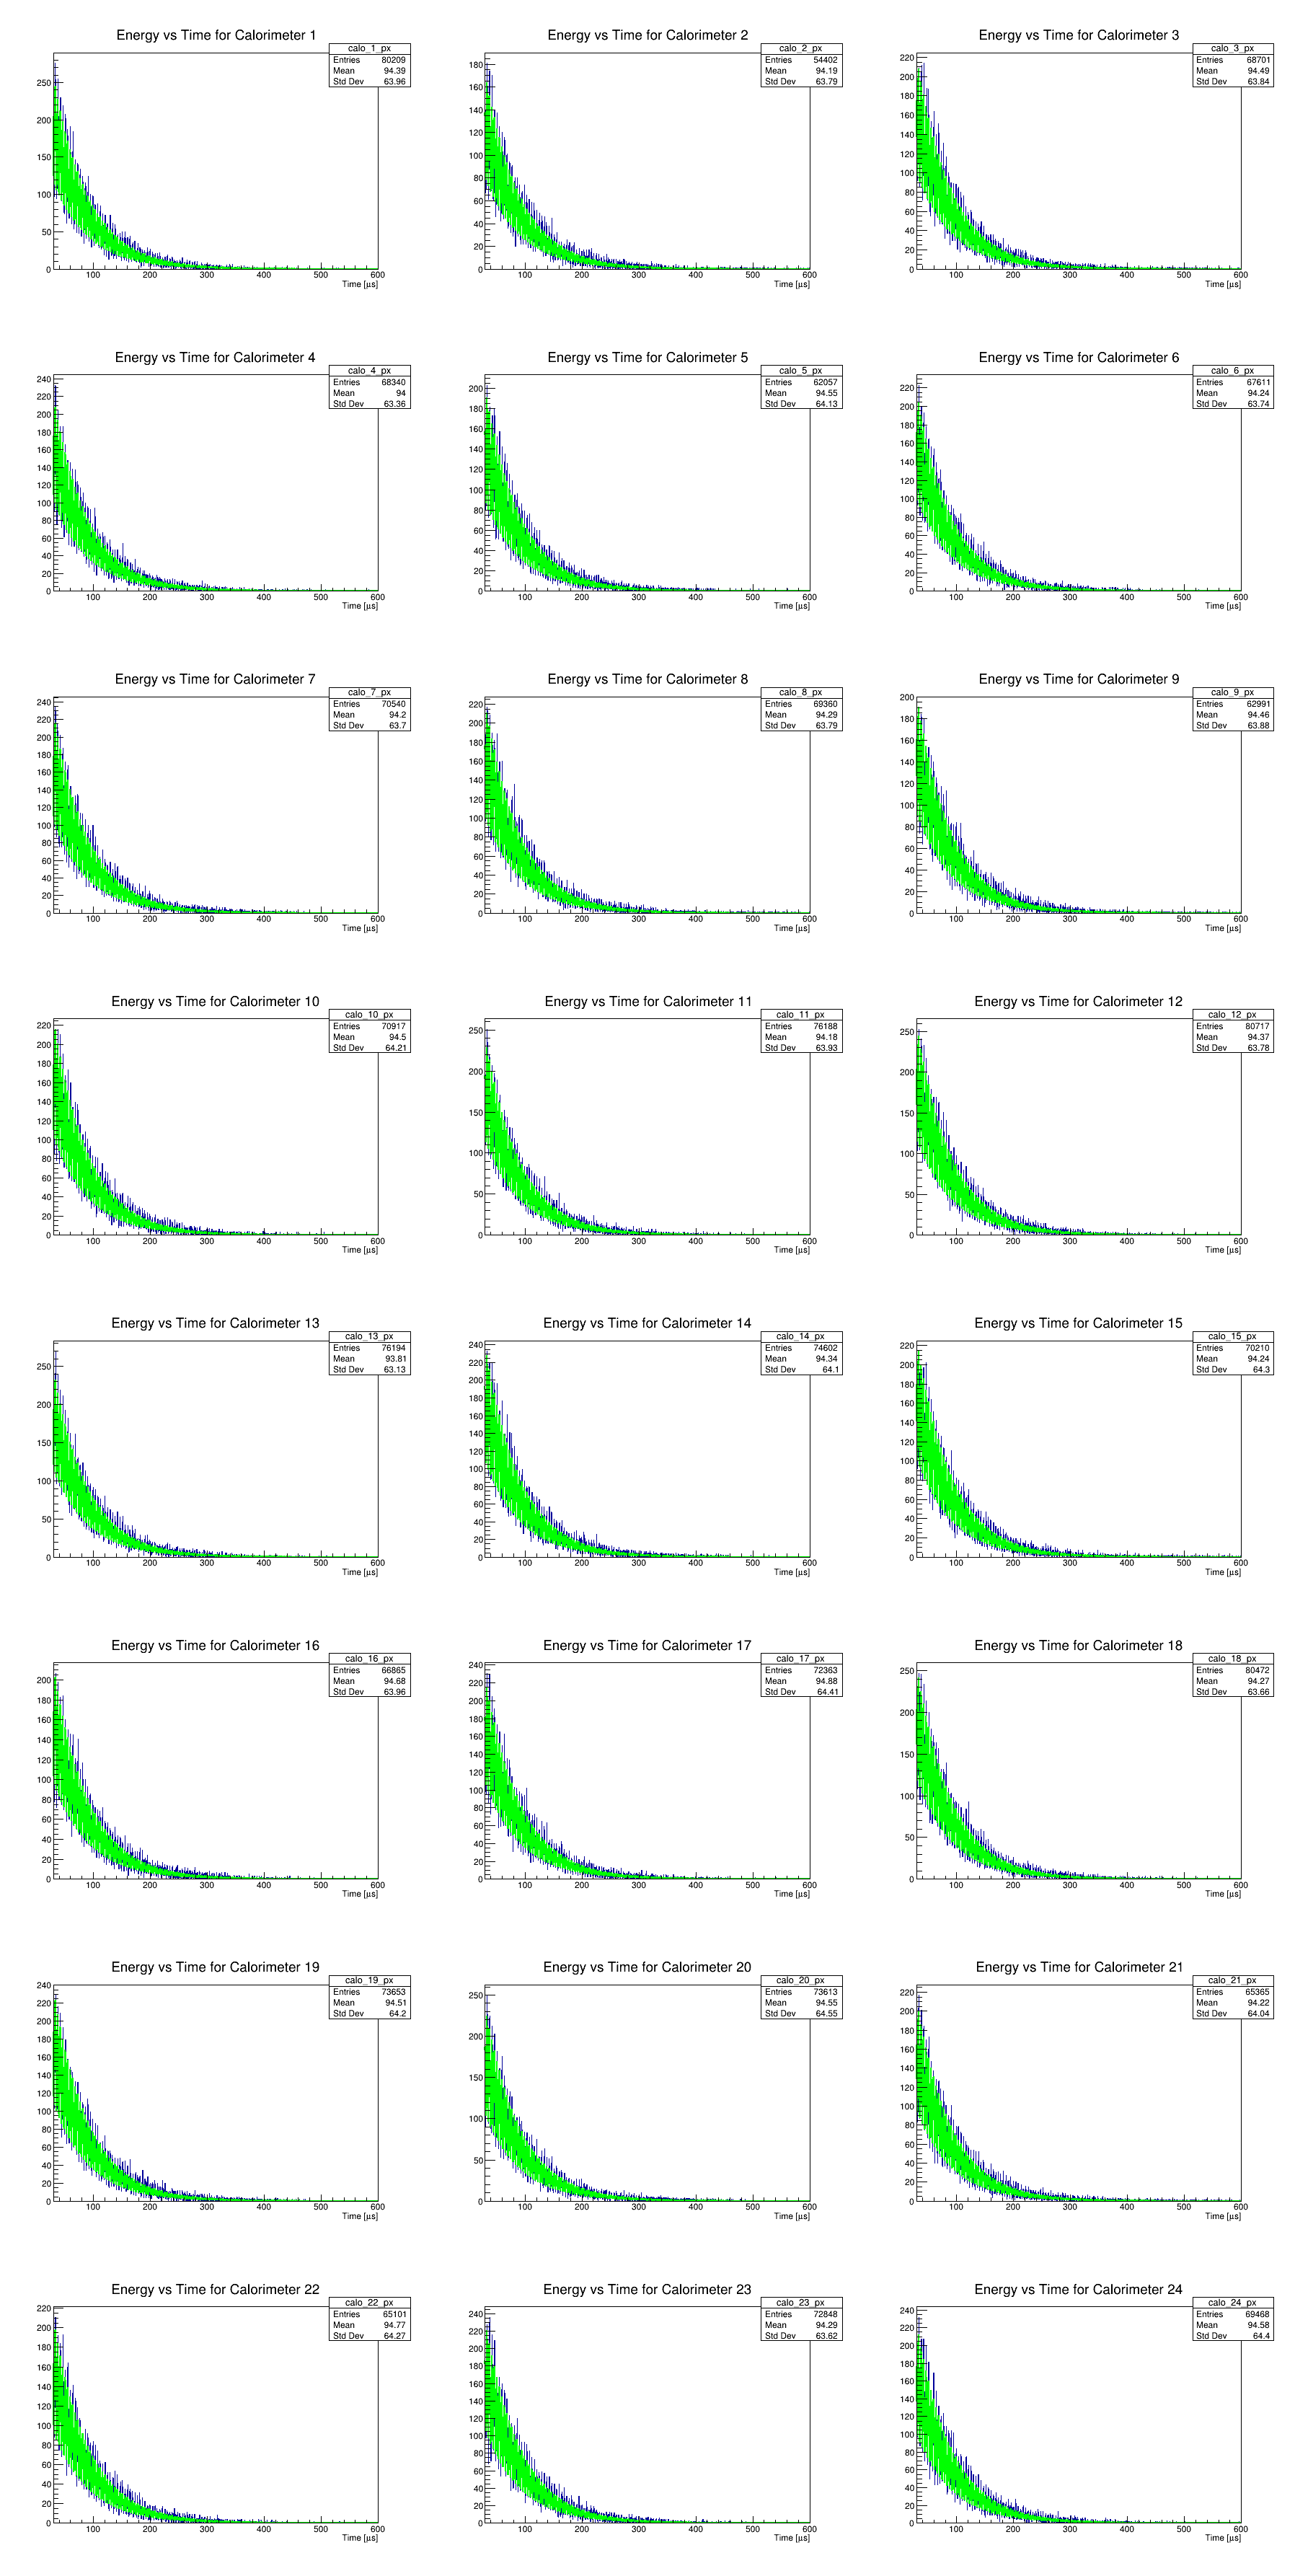

In [7]:
"""
Plot the energy vs time histograms for each calorimeter
"""

eLow = 1700
eHigh = 6000

c = r.TCanvas("c", "c", 1800, 3600)
c.Divide(3, 8)

results = []
    
for i, hist in enumerate(hists):
    c.cd(i+1)
    
    binLow = hist.GetYaxis().FindBin(eLow)
    binHigh = hist.GetYaxis().FindBin(eHigh)

    hist.GetXaxis().SetRangeUser(30,600)
    hist.ProjectionX("_px", binLow, binHigh).Draw("colz")
    results.append(hist.ProjectionX("_px", binLow, binHigh).Fit("func", "REMQS"))
    #hist.ProjectionX("_px", binLow, binHigh).Fit("func", "REMQ")
    
    r.gPad.SetLogz()
c.Draw()

In [8]:
"""
Put the results into a pandas dataframe to look at
"""

results_df = pd.DataFrame(columns = ['N', '#tau', 'A', 'R #omega', '#phi'])

for index in range(0, 24):
    results_df.loc[index] = pd.Series({'N':results[index].Parameter(0),
                                       '#tau':results[index].Parameter(1),
                                       'A':results[index].Parameter(2),
                                       'R #omega':results[index].Parameter(3),
                                       '#phi':results[index].Parameter(4)})

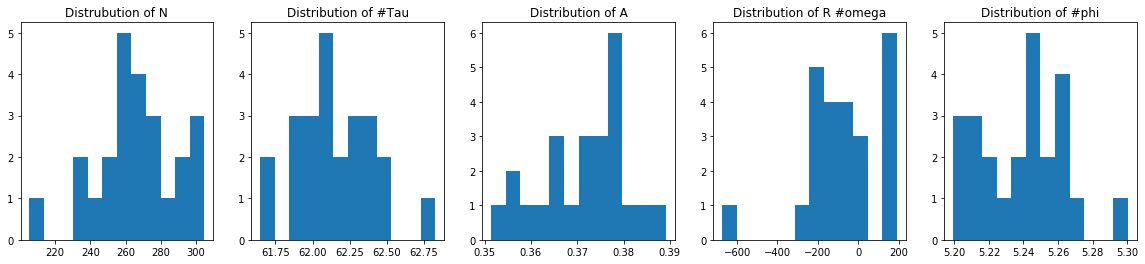

In [9]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20,4)

ax[0].hist(results_df['N'], bins=12);
ax[0].set_title('Distrubution of N');

ax[1].hist(results_df['#tau'], bins=12);
ax[1].set_title('Distribution of #Tau');

ax[2].hist(results_df['A'], bins=12);
ax[2].set_title('Distribution of A');

ax[3].hist(results_df['R #omega'], bins=12);
ax[3].set_title('Distribution of R #omega');

ax[4].hist(results_df['#phi'], bins=12);
ax[4].set_title('Distribution of #phi');

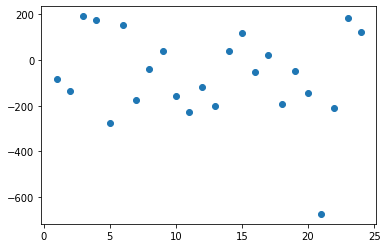

In [12]:
fig, ax = plt.subplots(1,1)

ax.scatter(range(1,25), results_df['R #omega'])